# IA Project - Face Recognition with Dynamic Triplet Loss

References: https://openaccess.thecvf.com/content_ICCV_2019/papers/Zhang_Learning_Local_Descriptors_With_a_CDF-Based_Dynamic_Soft_Margin_ICCV_2019_paper.pdf

Dataset: http://vis-www.cs.umass.edu/lfw/#download

In [1]:
import torch
from matplotlib import pyplot as plt
from torchvision import datasets
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import numpy as np
import collections
import PIL.Image
from torch.utils.data import DataLoader, Subset
import os
import random

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cpu


### Pre-precessing data

In [3]:
#path
data_path = "./LFW_DIR"
train_path = "./data/train_pairs.txt"
test_path = "./data/test_pairs.txt"
people_path = "./data/people.txt"

In [4]:
norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225)

test_transform = T.Compose([
    T.Resize(250),  # make 250x250
    T.CenterCrop(150),   # then take 150x150 center crop
    T.ToTensor(),
    T.Normalize(norm_mean, norm_std),
])

train_transform = T.Compose([
    T.Resize(250),
    T.RandomCrop(150),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(norm_mean, norm_std),
])

In [5]:
def readPeople(people_path):
  people_list = []
  with open(people_path, 'r') as file:
    for line in file.readlines():
      person = line.strip().split()
      people_list.append(person)
  return people_list

In [6]:
people_list= readPeople(people_path)
# people_list

In [7]:
# cambiare i nomi con le labels
def getLabeledImages(data_path, people_list):
  labeledImages = {}
  label = 0
  

  for person in people_list:
    if int(person[1]) > 1:    # se ho più di una immagine per persona
      for img_id in range(1, int(person[1])+1):
        path = os.path.join(data_path, person[0], person[0] + '_' + '%04d' % img_id + '.jpg')
        labeledImages[path] = label
      label += 1

  return labeledImages

In [8]:
labeledImages = getLabeledImages(data_path, people_list)
print(len(labeledImages.keys()))    # dizionario 'img_path: label'
print(len(set(labeledImages.values())))

9164
1680


In [50]:
class LFWDataset(torch.utils.data.Dataset):

  def __init__(self, labeledImages, train=True, transform=None):
    self.transform = transform
    self.labeledImages = labeledImages
    self.images = list(labeledImages.keys())
    self.train = train
    # self.indeces = indeces

  def __len__(self):
    return len(self.images)

  #def getLabel(self, anchor_img):
    

  def __getitem__(self, index):
    anchor_path = self.images[index]
    anchor_label = self.labeledImages[anchor_path]
    anchor_img = PIL.Image.open(anchor_path)

    if self.train:
      # get positive image path
      positive_list = [item for item in self.images if self.labeledImages[item] == anchor_label and item != anchor_path]
      positive_path = random.choice(positive_list)

      # get negative image path
      negative_list = [item for item in self.labeledImages.keys() if item not in positive_list]
      negative_path = random.choice(negative_list)

      # get images from paths
      positive_img = PIL.Image.open(positive_path)
      negative_img = PIL.Image.open(negative_path)

    # transform images
      if self.transform:
        anchor_img = self.transform(anchor_img)
        positive_img = self.transform(positive_img)
        negative_img = self.transform(negative_img)

      return anchor_img, positive_img, negative_img, anchor_label

    else:
      if self.transform:
        anchor_img = self.transform(anchor_img)
      return anchor_img, anchor_label

In [51]:
lfw_dataset = LFWDataset(labeledImages)

In [53]:
# Compute dataset sizes
num_data = len(lfw_dataset)
print(f"Num. samples: {num_data}")

Num. samples: 9164


In [54]:
# List of indexes on the dataset
list_idx = list(range(num_data))
random.shuffle(list_idx)

In [55]:
#test fraction
test_frac = 0.1
# Compute number of samples
num_test = int(num_data*test_frac)
num_data = num_data - num_test
# Split set
test_idx = list_idx[num_data:]
list_idx = list_idx[:num_data]

In [56]:
# Split 
test_dataset = Subset(lfw_dataset, test_idx)
dataset = Subset(lfw_dataset, list_idx)

In [57]:
#validation fraction
val_frac = 0.1
# Compute number of samples
num_val = int(num_data*val_frac)
num_data = num_data - num_val
# Split set
val_idx = list_idx[num_data:]
list_idx = list_idx[:num_data]

In [58]:
# Split train_dataset into training and validation
val_dataset = Subset(lfw_dataset, val_idx)
train_dataset = Subset(lfw_dataset, list_idx)

In [59]:
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform
val_dataset.dataset.transform = test_transform
test_dataset.dataset.train = False
val_dataset.dataset.train = False

In [60]:
num_train = len(train_dataset)
num_test = len(test_dataset)
num_val = len(val_dataset)

print(f"Num. training samples: {num_train}")
print(f"Num. test samples: {num_test}")
print(f"Num. val samples: {num_val}")

Num. training samples: 7424
Num. test samples: 916
Num. val samples: 824


In [61]:
# Define loaders
train_loader = DataLoader(train_dataset, batch_size=64, num_workers=4, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, num_workers=4, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=64, num_workers=4, shuffle=False)

In [62]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

### Dynamic Triplet Loss implementation

In [63]:
class TripletLoss(nn.Module):
  def __init__(self, margin = 0.2):
    super(TripletLoss, self).__init__()
    self.margin = margin

  def pairwise_dist(x, y):
    dist = torch.sqrt((x - y).pow(2).sum(1))
    return dist

  def forward(self, anchor, positive, negative):
    margin = self.margin
    pos_dist = pairwise_dist(anchor, positive)
    print(pos_dist, pos_dist.shape)
    neg_dist = pairwise_dist(anchor, negative)
    print(neg_dist)
    loss = pos_dist - neg_dist + margin
    loss = torch.clamp(loss, min = 0.0).sum
    return loss

### CNN Model

In [64]:
len(set(labeledImages.values()))

1680

In [65]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 150, kernel_size=5, padding=0, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(150),
            # nn.Dropout(0.3),

            nn.Conv2d(150, 256, kernel_size=5, padding=0, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            # nn.Dropout(0.3)
          
            nn.Conv2d(256, 256, kernel_size=5, padding=0, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.BatchNorm2d(256),
            # nn.Dropout(0.3)

            nn.Conv2d(256, 512, kernel_size=5, padding=0, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.BatchNorm2d(512),
            # nn.Dropout(0.3)
        )
  
        self.fc_layers = nn.Sequential(
            nn.Linear(8192, 4096),
            nn.PReLU(),
            nn.Linear(4096, 1680)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

### Training Loop


In [71]:
def train(epochs, dev, lr = 0.001):
  try:
    model = CNN()
    model.to(dev)
    print(model)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history_loss = {"train": [], "val": [], "test": []}
    # history_accuracy = {"train": [], "val": [], "test": []}

    for epoch in range(epochs):
      sum_loss = {"train": 0, "val": 0, "test": 0}
      # sum_accuracy = {"train": 0, "val": 0, "test": 0}
      for split in ["train", "val", "test"]:
        for step,(anchor_img, positive_img, negative_img, anchor_label) in enumerate(loaders[split]):

          # Move to CUDA
          anchor_img = anchor_img.to(device)
          positive_img = positive_img.to(device)
          negative_img = negative_img.to(device)

          # Reset gradients
          optimizer.zero_grad()
          # Compute output
          anchor_out = model(anchor_img)
          positive_out = model(positive_img)
          negative_out = model(negative_img)

          loss = TripletLoss(anchor_out, positive_out, negative_out)

          # Update loss
          sum_loss[split] += l

          # Check parameter update
          if split == 'train':
            loss.backward()
            optimizer.step()

      # Compute epoch loss
      epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
      # Update history
      for split in ["train", "val", "test"]:
        history_loss[split].append(epoch_loss[split])
      
      # Print info
      print(f"Epoch {epoch+1}:",
            f"TrL={epoch_loss['train']:.4f},"
            f"VL={epoch_loss['val']:.4f},",
            f"TeL={epoch_loss['test']:.4f},"
            ) 
  except KeyboardInterrupt:
    print("Interrupted")
  finally:
    # Plot loss
    plt.title("Loss")
    for split in ["train", "val", "test"]:
      plt.plot(history_loss[split], label=split)
    plt.legend()
    plt.show()

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 150, kernel_size=(5, 5), stride=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(150, 256, kernel_size=(5, 5), stride=(1, 1))
    (5): PReLU(num_parameters=1)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1))
    (9): PReLU(num_parameters=1)
    (10): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1))
    (13): PReLU(num_parameters=1)
    (14): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1

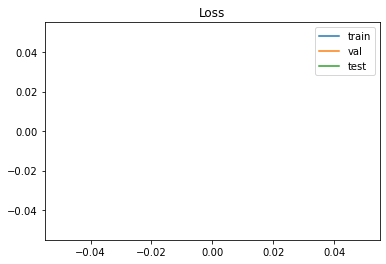

ValueError: ignored

In [72]:
train(100, dev, 0.001)